In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import *
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

# Mnist Dataset Loading, Preprocessing, Splitting

In [6]:
import idx2numpy
x_train_main = idx2numpy.convert_from_file("train-images.idx3-ubyte")
x_test = idx2numpy.convert_from_file("t10k-images.idx3-ubyte")
y_train_main = idx2numpy.convert_from_file("train-labels.idx1-ubyte")
y_test = idx2numpy.convert_from_file("t10k-labels.idx1-ubyte")

In [7]:
# print(x_train_main.shape)
x_train_main = x_train_main.reshape(60000,-1)
print(x_train_main.shape)
x_test = x_test.reshape(10000,-1)
print(x_test.shape)

(60000, 784)
(10000, 784)


**Preprocessing**

In [8]:
from sklearn.preprocessing import OneHotEncoder
# since all color values are between 0 and 255, we can divide by 255 to normalize
x_train_main = x_train_main/255
x_test = x_test/255
x_train_main = x_train_main.reshape(x_train_main.shape[0],-1)
print(x_train_main.shape)
x_test = x_test.reshape(x_test.shape[0],-1)
print(x_test.shape)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train_main)
y_train_main = le.transform(y_train_main)
le.fit(y_test)
y_test = le.transform(y_test)

(60000, 784)
(10000, 784)


**Splitting the dataset in x_train , x_val , x_test , y_train , y_val , y_test**

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_main, y_train_main, test_size=0.2, random_state=43)


# My neural network

In [10]:
class NeuralNetwork:
    activation_type = None
    weight_init_type = None
    neuron_layers = None
    layer_sizes = None
    learning_rate = None
    batch_size = None
    epochs = None

    # loss arrays - 
    final_training_loss = []
    final_validation_loss = []
    final_testing_loss = []
    w = {}
    b = {}

    # init function to initialize the parameters
    def __init__(self, activation_type, weight_init_type, neuron_layers,layer_sizes , learning_rate, batch_size, epochs , x_train , y_train , x_val , y_val , x_test , y_test):
        """
            MyNeuralNetwork initialization function

            Parameters
            ----------
            activation_type : string specifying the activation function to be used
                        possible inputs: relu, sigmoid, linear, tanh , leaky_relu
            
            weight_init_type : string specifying the w initialization function to be used
                        possible inputs: zero, random, normal

            neuron_layers : int value specifying the number of layers

            layer_sizes : integer array of size n_layers specifying the number of nodes in each layer

            learning_rate : float value  - the learning rate that will be used in gradient descent      

            batch_size : int value - batch size that will be used for mini-batch gradient descent

            epochs : int value specifying the number of iterations to be used
        """
        
        # handling errors to make sure the input by user is correct
        if activation_type not in ['relu', 'sigmoid', 'linear', 'tanh', 'softmax' , 'leaaky_relu']:
            raise ValueError("activation_type must be relu, sigmoid, linear, tanh or softmax")
        if weight_init_type not in ['zero_init', 'random_init', 'normal_init']:
            raise ValueError("weight_init_type must be zero_init, random_init or normal_init")
        if neuron_layers != len(layer_sizes):
            raise ValueError("neuron_layers must be equal to length of layer_sizes")

        # store the parameters
        self.activation_type = activation_type
        self.weight_init_type = weight_init_type
        self.neuron_layers = neuron_layers
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

        # initializing all the weights and biases based on the input parameters
        for i in range(1,self.neuron_layers):
            shape_weight   = (layer_sizes[i-1],layer_sizes[i])
            shape_bias = (1,layer_sizes[i])
            self.b[i]   = np.zeros(shape_bias)
            self.w[i] = self.weight_init(self.weight_init_type,shape_weight)
        
        # Calling the runner function that runs models and saves them and prints their accuracies
        self.runner(x_train , y_train , x_val , y_val , x_test , y_test)

    # activation function 
    def activation_function(self, type , x):
        if type == 'relu':
            X_mod = np.array(x,copy = True)
            X_mod[X_mod<0] = 0
            return X_mod
        
        elif type == 'sigmoid':
            return 1/(1+np.exp(-x))

        elif type == 'linear':
            return x

        elif type == 'tanh':
            return np.tanh(x)

        elif type == 'leaaky_relu':
            X_mod = np.array(x,copy = True)
            X_mod[X_mod<0] = 0.01*X_mod[X_mod<0]
            return X_mod
        
        elif type == 'softmax':
            numerator   = np.exp(x)
            denominator = np.sum(numerator,axis=1,keepdims=True) 
            return numerator/denominator

    # derivative of activation function
    def act_func_gradient(self , type , x):
        if type == 'relu':
            X_mod = np.array(x,copy = True)
            X_mod[X_mod >= 0] = 1
            X_mod[X_mod < 0] = 0        
            return X_mod
        
        elif type == 'sigmoid':
            sigmoid_x = 1/(1+np.exp(-x)) 
            return (1-sigmoid_x)*sigmoid_x

        elif type == 'linear':
            return np.ones(x.shape)

        elif type == 'tanh':
            tanh_x = np.tanh(x)
            return 1 - (tanh_x*tanh_x)
        
        elif type == 'leaaky_relu':
            X_mod = np.array(x,copy = True)
            X_mod[X_mod >= 0] = 1
            X_mod[X_mod < 0] = 0.01        
            return X_mod
        
        elif type == 'softmax':
            return None

    # w initialization function
    def weight_init(self, type ,shape):
        if(type == 'zero_init'):
            return np.zeros(shape[0] , shape[1])
        elif(type == 'random_init'):
            return 0.01 * np.random.rand(shape[0],shape[1])
        elif(type == 'normal_init'):
            return np.random.normal(loc= 0 ,scale=0.01,size = shape)

    # divide the data into batches
    def get_batches(self,x,y_train):
        batches = []
        num_min_batch = x.shape[0]//self.batch_size
        i=0
        while i < num_min_batch:
            X_mini = x[i * self.batch_size:(i + 1)*self.batch_size, :]
            y_mini = y_train[i * self.batch_size:(i + 1)*self.batch_size, :]
            batches.append([X_mini,y_mini])
            i = i+1
        if(i*self.batch_size != x.shape[0]):
            X_mini = x[i * self.batch_size :, :]
            y_mini = y_train[i * self.batch_size :, :]
            batches.append([X_mini,y_mini])
        return batches

    # forward propagation
    def forward_propogation(self,x):
        pre_activation_val = {}
        activation_val = {}
        input = x
        activation_val[0] = input
        for i in range(1,self.neuron_layers -1):
            pre_activation_val[i] = np.dot(input,self.w[i]) + self.b[i] 
            activation_val[i] = self.activation_function(self.activation_type,pre_activation_val[i])
            input = activation_val[i]                      
        pre_activation_val[self.neuron_layers-1] =  np.dot(input,self.w[self.neuron_layers -1]) + self.b[self.neuron_layers-1]                 
        activation_val[self.neuron_layers-1]  = self.activation_function('softmax',pre_activation_val[self.neuron_layers-1])
        return (pre_activation_val,activation_val)

    # backward propagation
    def backward_propogation(self , y_real , pre_activation_val , activation_val):
        slopes = {}
        current = self.neuron_layers - 1
        slopes[current] = activation_val[current] - y_real
        der_activation = {}
        for current in range(self.neuron_layers - 2,0,-1):
            der_activation[current] = np.dot(slopes[current+1],self.w[current+1].T)            
            slopes[current] = der_activation[current] * self.act_func_gradient(self.activation_type,pre_activation_val[current])
        for i in range(self.neuron_layers-1,0,-1):
            self.w[i] = self.w[i] - (self.learning_rate/self.batch_size) * np.dot(activation_val[i-1].T,slopes[i])
            self.b[i] = self.b[i] - (self.learning_rate/self.batch_size)* np.sum(slopes[i],axis=0,keepdims=True)
        return slopes

    # model fitting
    def fit(self, x, y_train, X_valid=None, y_valid=None):
        #  one hot encoding of y_valid and y_train
        if y_train is not None:
            y_real = self.one_hot_encoding(y_train)
        if y_valid is not None:
            y_valid_orig = self.one_hot_encoding(y_valid)
        

        #  gettting batches of data
        batches = self.get_batches(x,y_real)
        for epoch in (range(self.epochs)):
            for batch in batches:
                loss = []
                X_batch = batch[0]
                Y_batch = batch[1]
                pre_activation_val,activation_val = self.forward_propogation(X_batch)
                loss.append(self.cross_entropy_loss(Y_batch,activation_val[self.neuron_layers-1]))
                self.backward_propogation(Y_batch,pre_activation_val,activation_val)
            if((epoch) % 10 == 0):
                print("Iteration :",epoch," Training Loss :",np.array(loss).mean())         
            self.final_training_loss.append(np.array(loss).mean())
            
            if X_valid is not None:
                y_pred_val = self.predict_proba(X_valid)
                self.final_validation_loss.append(self.cross_entropy_loss(y_valid_orig,y_pred_val))               
        return self
    
    # this function takes in the y_train and returns it in one hot encoded form
    def one_hot_encoding(self,y_train):
        y_one_hot = np.zeros((y_train.size,(y_train.max() + 1)))
        y_one_hot[np.arange(y_train.size),y_train] = 1
        return y_one_hot

    # log loss function
    def cross_entropy_loss(self,y_real,y_pred):
        cross_entropy = np.sum(-np.log(y_pred[np.arange(y_real.shape[0]),y_real.argmax(axis=1)]))
        return cross_entropy/y_real.shape[0]

    # predicting the class
    def predict(self, x):
        probab = self.predict_proba(x)
        return probab.argmax(axis=1)

    # giving the score of the model
    def score(self, x, y_train):
        y_pred = self.predict(x)
        count=0
        for i in range(len(y_pred)):
            if(y_pred[i]==y_train[i]):
                count= count + 1
        return count/len(y_pred)
    
    # predicting probabilities to be used for prediction
    def predict_proba(self, x):
        waste ,activation_val = self.forward_propogation(x)
        return activation_val[self.neuron_layers-1]

    # plotting the loss curves
    def plot_loss(self):
        plt.plot(self.final_training_loss , label = "Training  Loss")
        plt.plot(self.final_validation_loss , label = "Validation  Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Training Loss','Validation Loss'])
        plt.title('Loss Curves-'+ self.activation_type + " " +self.weight_init_type)
        plt.show()
    
    # saving the model
    def save(self,path_with_name):
        model_op = open(path_with_name,"wb")
        pickle.dump(self,model_op)
        model_op.close()

    def runner(self,X_train,y_train,X_valid,y_valid , X_test , y_test):
        self.fit(X_train,y_train,X_valid,y_valid)
        self.plot_loss()
        print("Training Accuracy :",self.score(X_train,y_train))
        print("Validation Accuracy :",self.score(X_valid,y_valid))
        print("Test Accuracy :",self.score(X_test,y_test))
        self.save(self.activation_type + "_" +self.weight_init_type + "_model.pkl")


# final MODELS

Activation :  linear  Weight Init :  normal_init
Iteration : 0  Loss : 2.297737739141917
Iteration : 10  Loss : 0.2734891850071367
Iteration : 20  Loss : 0.2744770263305355
Iteration : 30  Loss : 0.2673574494583894
Iteration : 40  Loss : 0.22214513644606027
Iteration : 50  Loss : 0.21079299088139386
Iteration : 60  Loss : 0.2054334226198568
Iteration : 70  Loss : 0.2012873835292963
Iteration : 80  Loss : 0.19765416846440778
Iteration : 90  Loss : 0.19443061570166084
Iteration : 100  Loss : 0.19157444746902233
Iteration : 110  Loss : 0.1890388319357988


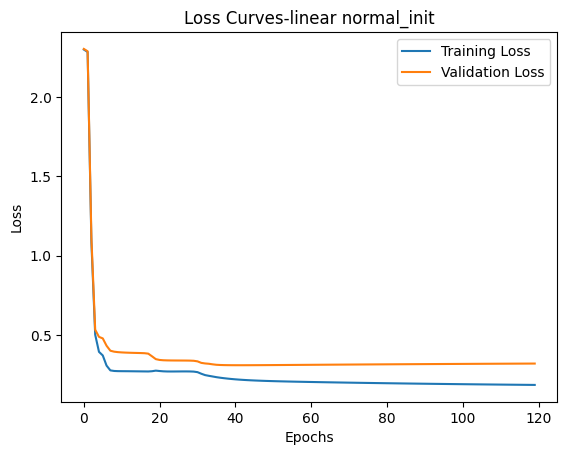

Training Accuracy : 0.9297083333333334
Validation Accuracy : 0.9099166666666667
Test Accuracy : 0.919
Activation :  linear  Weight Init :  random_init
Iteration : 0  Loss : 1.6068225578729887
Iteration : 10  Loss : 0.9189610097377939
Iteration : 20  Loss : 0.5490014315613998
Iteration : 30  Loss : 0.35034432410482574
Iteration : 40  Loss : 0.3478170637322819
Iteration : 50  Loss : 0.3525412283183392
Iteration : 60  Loss : 0.35502040672695945
Iteration : 70  Loss : 0.3561282938938144
Iteration : 80  Loss : 0.35677513007433337
Iteration : 90  Loss : 0.357236348039211
Iteration : 100  Loss : 0.3575931071221872
Iteration : 110  Loss : 0.3578764034063269


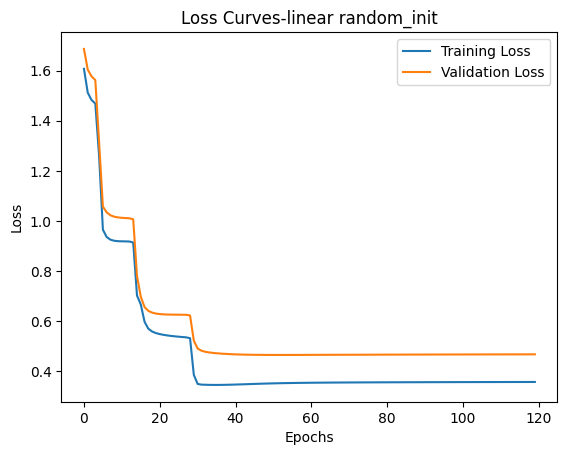

Training Accuracy : 0.880625
Validation Accuracy : 0.8678333333333333
Test Accuracy : 0.8717
Activation :  relu  Weight Init :  normal_init
Iteration : 0  Loss : 2.2980991615439788
Iteration : 10  Loss : 0.084899879897648
Iteration : 20  Loss : 0.013633268258924382
Iteration : 30  Loss : 0.00269103606180833
Iteration : 40  Loss : 0.001212630455911897
Iteration : 50  Loss : 0.0007022283921416343
Iteration : 60  Loss : 0.00047258025966881066
Iteration : 70  Loss : 0.00034749639176280154
Iteration : 80  Loss : 0.00027009224216240985
Iteration : 90  Loss : 0.00021777812093974172
Iteration : 100  Loss : 0.00018270615315053474
Iteration : 110  Loss : 0.00015510423554446648


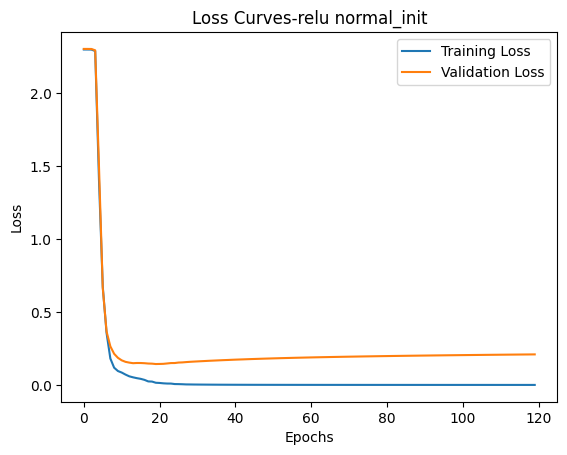

Training Accuracy : 1.0
Validation Accuracy : 0.97075
Test Accuracy : 0.9712
Activation :  relu  Weight Init :  random_init
Iteration : 0  Loss : 1.7750414310083469
Iteration : 10  Loss : 0.18755173173365344
Iteration : 20  Loss : 0.013096611354640447
Iteration : 30  Loss : 0.005962738312378438
Iteration : 40  Loss : 0.002765261086661629
Iteration : 50  Loss : 0.0016691586795590208
Iteration : 60  Loss : 0.0011936731472224934
Iteration : 70  Loss : 0.0008535503660353687
Iteration : 80  Loss : 0.0006513018849483091
Iteration : 90  Loss : 0.0005261875829071333
Iteration : 100  Loss : 0.00044207092812661704
Iteration : 110  Loss : 0.00037972603855959675


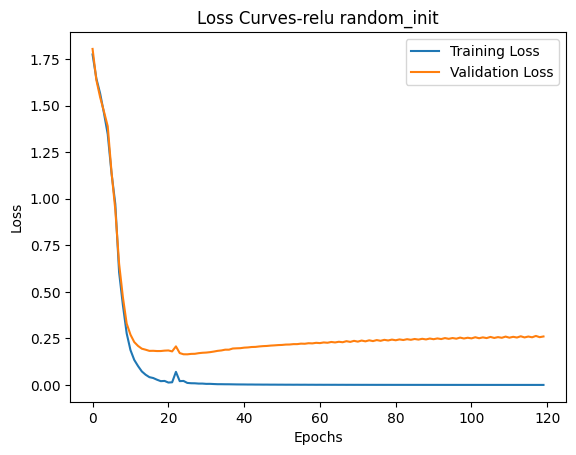

Training Accuracy : 0.9999375
Validation Accuracy : 0.96525
Test Accuracy : 0.968
Activation :  tanh  Weight Init :  normal_init
Iteration : 0  Loss : 2.2977458599285248
Iteration : 10  Loss : 0.10236696583576581
Iteration : 20  Loss : 0.031025402747564317
Iteration : 30  Loss : 0.014264871935252728
Iteration : 40  Loss : 0.006966015609732722
Iteration : 50  Loss : 0.003047558579817484
Iteration : 60  Loss : 0.0019542480733813036
Iteration : 70  Loss : 0.0014669475258015673
Iteration : 80  Loss : 0.0011604903295380198
Iteration : 90  Loss : 0.0009339744880166871
Iteration : 100  Loss : 0.0007223461577593288
Iteration : 110  Loss : 0.000582965025560506


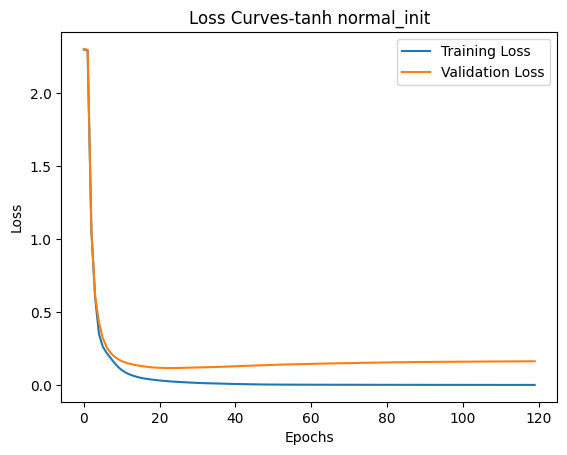

Training Accuracy : 0.9999791666666666
Validation Accuracy : 0.97
Test Accuracy : 0.9714
Activation :  tanh  Weight Init :  random_init
Iteration : 0  Loss : 1.6904501824101894
Iteration : 10  Loss : 0.14037452903364228
Iteration : 20  Loss : 0.08912381405538483
Iteration : 30  Loss : 0.06296471702404616
Iteration : 40  Loss : 0.018626104357498546
Iteration : 50  Loss : 0.008747973232218341
Iteration : 60  Loss : 0.006018396233138339
Iteration : 70  Loss : 0.00414817521067248
Iteration : 80  Loss : 0.0033992576172535323
Iteration : 90  Loss : 0.0027377878160525356
Iteration : 100  Loss : 0.0022787379575390835
Iteration : 110  Loss : 0.0018923655156683182


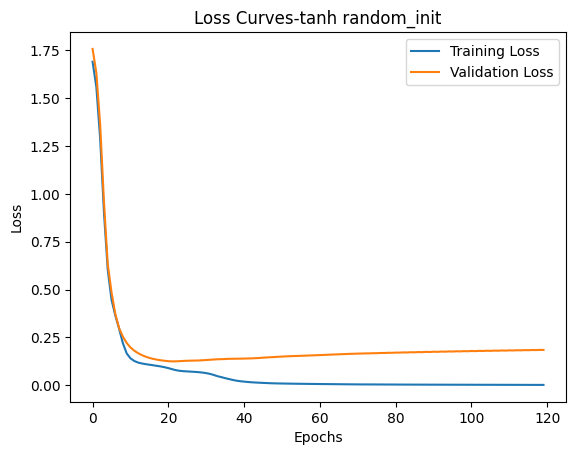

Training Accuracy : 0.9999791666666666
Validation Accuracy : 0.96775
Test Accuracy : 0.9703
Activation :  sigmoid  Weight Init :  normal_init
Iteration : 0  Loss : 2.300015207805557
Iteration : 10  Loss : 2.299526366667257
Iteration : 20  Loss : 2.299362932230461
Iteration : 30  Loss : 2.299183678859257
Iteration : 40  Loss : 2.297991085930711
Iteration : 50  Loss : 2.2089093266626927
Iteration : 60  Loss : 1.5958319516251556
Iteration : 70  Loss : 1.4044792363131031
Iteration : 80  Loss : 0.7440297065873043
Iteration : 90  Loss : 0.5209178082649388
Iteration : 100  Loss : 0.2644550476663086
Iteration : 110  Loss : 0.1859221737260305


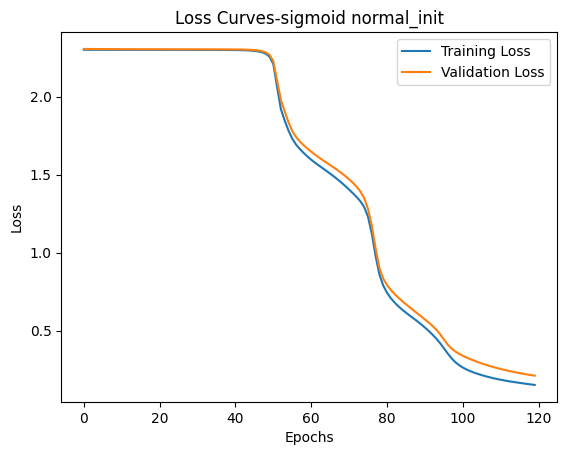

Training Accuracy : 0.9534583333333333
Validation Accuracy : 0.94075
Test Accuracy : 0.9449
Activation :  sigmoid  Weight Init :  random_init
Iteration : 0  Loss : 2.3000705969795154
Iteration : 10  Loss : 2.298736811861198
Iteration : 20  Loss : 2.2716630593783202
Iteration : 30  Loss : 1.6949858008085918
Iteration : 40  Loss : 1.2778723227068236
Iteration : 50  Loss : 1.0754390430164098
Iteration : 60  Loss : 0.9130445599808592
Iteration : 70  Loss : 0.5094548091627042
Iteration : 80  Loss : 0.2671612004962426
Iteration : 90  Loss : 0.16364908330066838
Iteration : 100  Loss : 0.12461117717732309
Iteration : 110  Loss : 0.09739190989617613


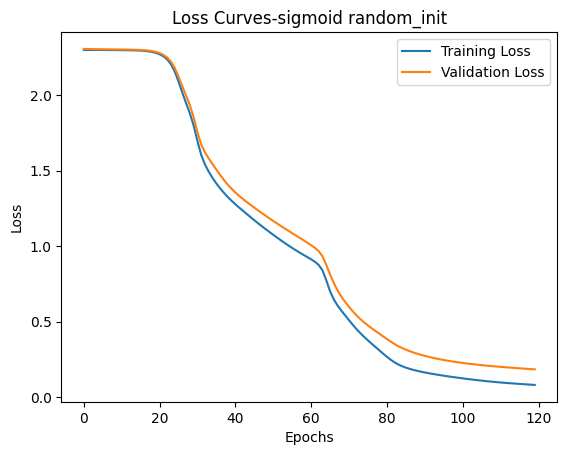

Training Accuracy : 0.9700416666666667
Validation Accuracy : 0.94925
Test Accuracy : 0.9533
Activation :  leaaky_relu  Weight Init :  normal_init
Iteration : 0  Loss : 2.2980841446326004
Iteration : 10  Loss : 0.06223857935932317
Iteration : 20  Loss : 0.007213398595932985
Iteration : 30  Loss : 0.0018818118606358293
Iteration : 40  Loss : 0.0009226486957203161
Iteration : 50  Loss : 0.0005232120397433639
Iteration : 60  Loss : 0.00034322345640459877
Iteration : 70  Loss : 0.00025318094269416707
Iteration : 80  Loss : 0.00019715087168962724
Iteration : 90  Loss : 0.00016048296247461906
Iteration : 100  Loss : 0.0001341743125695769
Iteration : 110  Loss : 0.00011530978377185586


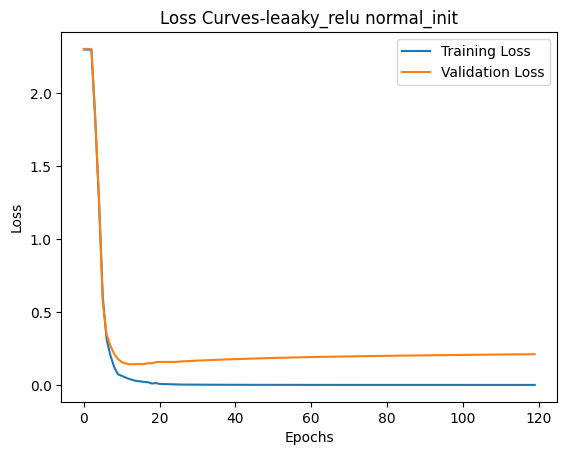

Training Accuracy : 1.0
Validation Accuracy : 0.9725833333333334
Test Accuracy : 0.9723
Activation :  leaaky_relu  Weight Init :  random_init
Iteration : 0  Loss : 1.775621627194404
Iteration : 10  Loss : 0.0982058021379473
Iteration : 20  Loss : 0.01230951112695278
Iteration : 30  Loss : 0.0020900934703706135
Iteration : 40  Loss : 0.001014756980751404
Iteration : 50  Loss : 0.004467081347717844
Iteration : 60  Loss : 0.0011800652605847806
Iteration : 70  Loss : 0.0007871481106143251
Iteration : 80  Loss : 0.0005581303701598973
Iteration : 90  Loss : 0.0004415937221447361
Iteration : 100  Loss : 0.00035029203030003287
Iteration : 110  Loss : 0.0002877019204165238


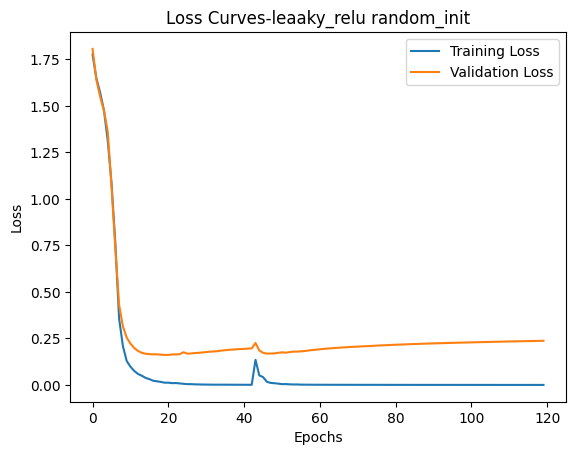

Training Accuracy : 0.9999791666666666
Validation Accuracy : 0.9679166666666666
Test Accuracy : 0.9682


In [71]:
activation = [ 'linear' , 'relu' , 'tanh' , 'sigmoid' , 'leaaky_relu' ]
weight_init = ['normal_init' , 'random_init' ]
for i in activation:
    for j in weight_init:
        print("Activation : ",i," w Init : ",j)
        model = NeuralNetwork(i , j, 5,[784,256,128,64,10], 0.1, 128, 120 , x_train , y_train , x_val , y_val , x_test , y_test)

Activation :  linear  w Init :  normal_init
Iteration : 0  Training Loss : 2.3021808767508953
Iteration : 10  Training Loss : 1.85053751416957
Iteration : 20  Training Loss : 0.47527532192349276
Iteration : 30  Training Loss : 0.4917691040417108
Iteration : 40  Training Loss : 0.49929751934587147
Iteration : 50  Training Loss : 0.38410483139045093
Iteration : 60  Training Loss : 0.36908072705419037
Iteration : 70  Training Loss : 0.37039646775345003
Iteration : 80  Training Loss : 0.3719002061918276
Iteration : 90  Training Loss : 0.37276905578144837
Iteration : 100  Training Loss : 0.37303170241503947
Iteration : 110  Training Loss : 0.37547296100988137
Iteration : 120  Training Loss : 0.3770327922083861
Iteration : 130  Training Loss : 0.3769153783032448
Iteration : 140  Training Loss : 0.37502505950301723
Iteration : 150  Training Loss : 0.36771722665493006
Iteration : 160  Training Loss : 0.3499244172894032
Iteration : 170  Training Loss : 0.3118204564247026
Iteration : 180  Traini

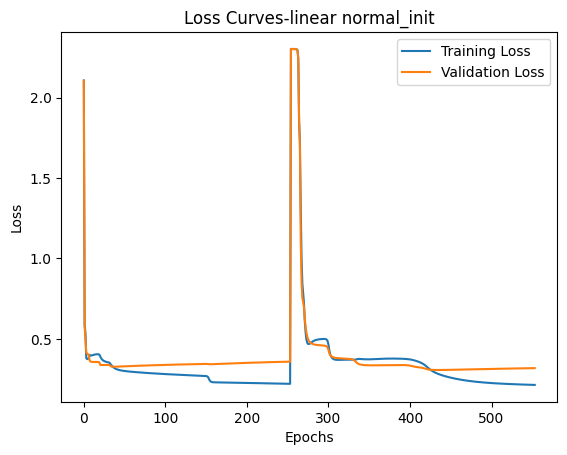

Training Accuracy : 0.9348125
Validation Accuracy : 0.9139166666666667
Test Accuracy : 0.9208
Activation :  linear  w Init :  random_init
Iteration : 0  Training Loss : 2.2491356196903682
Iteration : 10  Training Loss : 1.5327274609141777
Iteration : 20  Training Loss : 1.4705538027501506
Iteration : 30  Training Loss : 1.0299081874430422
Iteration : 40  Training Loss : 1.0073187509365975
Iteration : 50  Training Loss : 0.9949631282619011
Iteration : 60  Training Loss : 0.9495337741959378
Iteration : 70  Training Loss : 0.6889477496166494
Iteration : 80  Training Loss : 0.6319307514930754
Iteration : 90  Training Loss : 0.620594781344893
Iteration : 100  Training Loss : 0.6163284602755574
Iteration : 110  Training Loss : 0.6143576803680935
Iteration : 120  Training Loss : 0.6133403471591043
Iteration : 130  Training Loss : 0.6127483364784163
Iteration : 140  Training Loss : 0.6121653464182644
Iteration : 150  Training Loss : 0.5779300946068558
Iteration : 160  Training Loss : 0.4848867

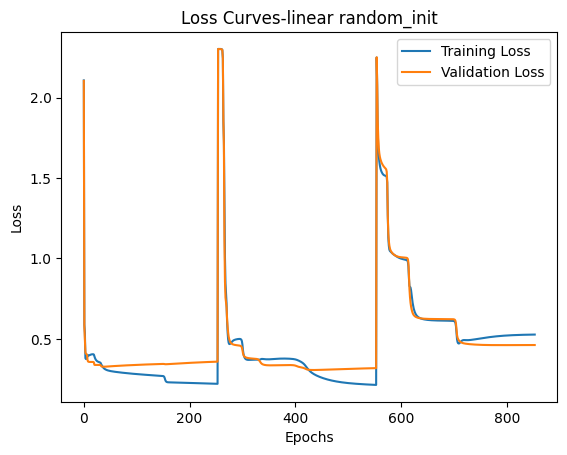

Training Accuracy : 0.8844583333333333
Validation Accuracy : 0.8689166666666667
Test Accuracy : 0.8732
Activation :  relu  w Init :  normal_init
Iteration : 0  Training Loss : 2.3022264664371086
Iteration : 10  Training Loss : 2.302723231456847
Iteration : 20  Training Loss : 2.299214346018255
Iteration : 30  Training Loss : 0.6961891752501346
Iteration : 40  Training Loss : 0.201571718445409
Iteration : 50  Training Loss : 0.12268582794445923
Iteration : 60  Training Loss : 0.08228172653649854
Iteration : 70  Training Loss : 0.05765677729004849
Iteration : 80  Training Loss : 0.031508668574179985
Iteration : 90  Training Loss : 0.015170363869321857
Iteration : 100  Training Loss : 0.008398566660201667
Iteration : 110  Training Loss : 0.005819056171636207
Iteration : 120  Training Loss : 0.004425374882790807
Iteration : 130  Training Loss : 0.0036566128852566623
Iteration : 140  Training Loss : 0.0030139484700950504
Iteration : 150  Training Loss : 0.002526683880517332
Iteration : 160 

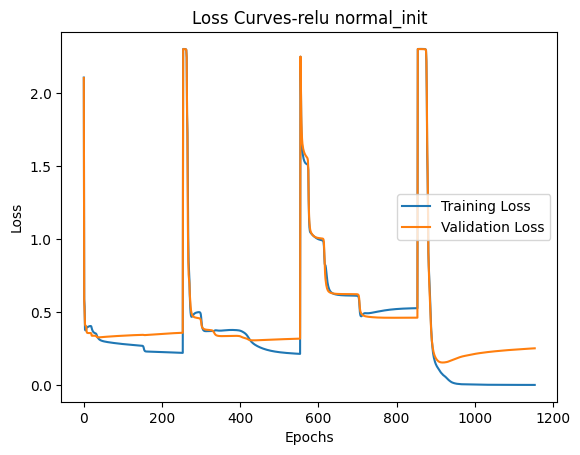

Training Accuracy : 1.0
Validation Accuracy : 0.9645833333333333
Test Accuracy : 0.9701
Activation :  relu  w Init :  random_init
Iteration : 0  Training Loss : 2.2489397938020055
Iteration : 10  Training Loss : 1.6813469834940875
Iteration : 20  Training Loss : 1.4343358213583517
Iteration : 30  Training Loss : 1.1306709353579045
Iteration : 40  Training Loss : 0.547306037835797
Iteration : 50  Training Loss : 0.20162380549740505


KeyboardInterrupt: 

In [12]:
activation = [ 'linear' , 'relu' , 'tanh' , 'sigmoid' , 'leaaky_relu' ]
weight_init = ['normal_init' , 'random_init' ]
for i in activation:
    for j in weight_init:
        print("Activation : ",i," w Init : ",j)
        model = NeuralNetwork(i , j, 5,[784,256,128,64,10], 0.05, 64, 300 , x_train , y_train , x_val , y_val , x_test , y_test)